In [20]:
import argparse
import os
import shutil
import time
import pandas as pd
import resnet
import matplotlib.pyplot as plt

import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

model_names = sorted(name for name in resnet.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("resnet")
                     and callable(resnet.__dict__[name]))

DATA_DIR = "train"

mixup = True
K = 4
print_freq = 50

In [2]:
train_df = pd.read_csv("trainLabels.csv")
train_df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])
train_df.head()

,id,label,label_enc
0,1,frog,6
1,2,truck,9
2,3,truck,9
3,4,deer,4
4,5,automobile,1


In [4]:
# 5-flod
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


# prepare dataset

In [5]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
        
        # Mixup part
        rd = np.random.rand()
        label2 = label
        gamma = np.array(np.ones(1)).astype(np.float32)[0]
        if mixup and rd < 0.5 and self.test is False:
            mix_idx = np.random.random_integers(0, len(self.df))
            row2 = self.df.iloc[mix_idx]
            img_id2 = row2.id
            images2 = cv2.imread(os.path.join(DATA_DIR, str(img_id2)+".png"))
            
            if self.transform is not None:
                images2 = self.transform(image=images2)['image']
            
            # blend image
            gamma = np.array(np.random.beta(1,1)).astype(np.float32)
            images = ((images*gamma + images2*(1-gamma))).astype(np.uint8)
            # blend labels
            label2 = row2.label_enc
              
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label), torch.tensor(label2), torch.tensor(gamma)

In [6]:
import albumentations as A
import albumentations

imsize = 32
transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                             val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, 
                                   contrast_limit=0.2, p=0.5),
    ],p=0.9),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    albumentations.Rotate(p=0.5),
    albumentations.Transpose(p=0.5),
    #albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
])
transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0)])

show imgs

/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: This function is deprecated. Please call randint(0, 50000 + 1) instead


tensor(0.0738)
tensor(0.2551)
tensor(0.7359)
tensor(1.)
tensor(0.0940)
tensor(0.6336)
tensor(1.)
tensor(0.6342)
tensor(0.6781)
tensor(1.)
tensor(1.)
tensor(0.2478)
tensor(0.0658)
tensor(1.)
tensor(0.8351)


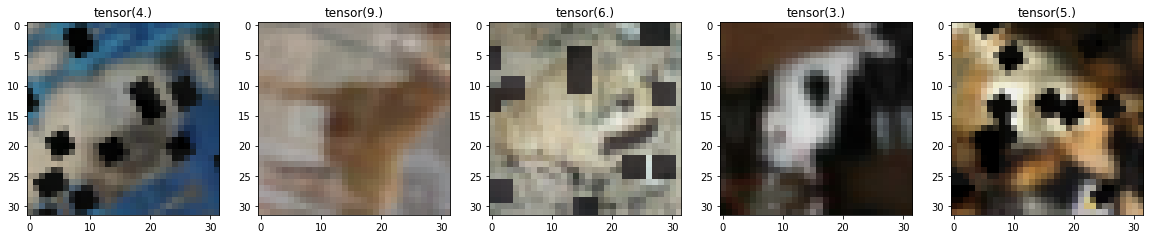

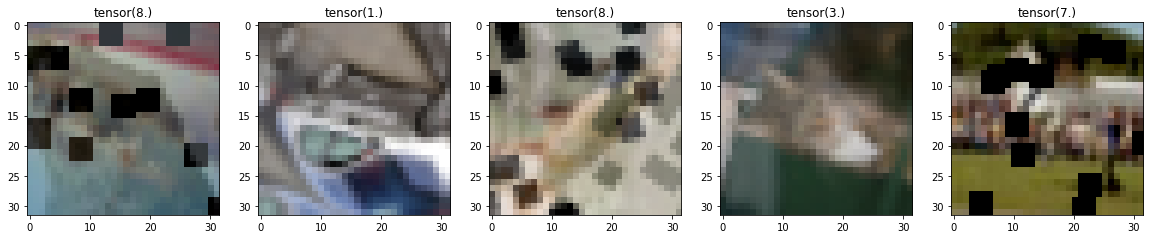

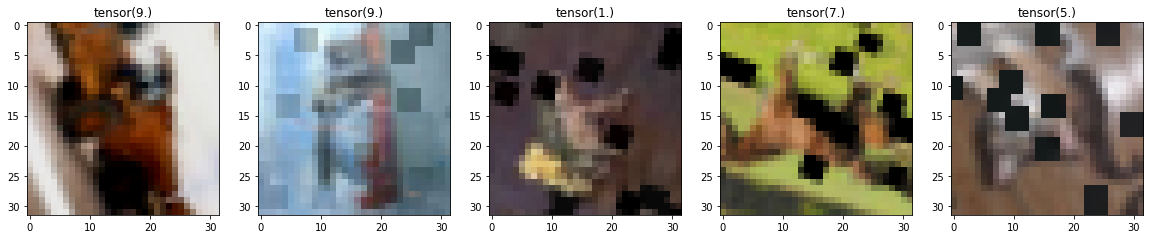

In [7]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label, label2, gamma = dataset_show[idx]
        print(gamma)
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))

# Trainer

In [16]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.00001
    for i, (data, target, target2, lam) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)
        data, target, target2, lam = data.to(device), target.to(device).long(), target2.to(device).long(), lam.to(device).float()
        
        # compute output
        output = model(data)
        if mixup:
            loss = mixup_criterion(criterion, output, target, target2, lam).mean()
        else:
            loss = criterion(output, target)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), data.size(0))
        top1.update(prec1.item(), data.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target, target2, lam) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

# Train loop

In [17]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=128, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=128, shuffle=False,
    num_workers=8, pin_memory=True)

In [18]:
from resnet_noquant import ResNet18
from resnet_orig import resnet20

model = resnet20(K)
model = model.cuda()

device = "cuda"

In [19]:
import wandb
watermark = "resnet20_quant{}".format(K)
if mixup:
    watermark+="_mixup"
wandb.init(project="pact",
            name=watermark)

wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [21]:
# define loss function (criterion) and pptimizer
criterion = nn.CrossEntropyLoss().cuda()
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                            momentum=0.9,
                            weight_decay=0.0002)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100-1)
#lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80, 150],)

best_prec1 = 0
os.makedirs("models", exist_ok=True)

for epoch in range(100):
    # train for one epoch
    print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
    tloss = train(train_loader, model, criterion, optimizer, epoch)
    lr_scheduler.step()

    # evaluate on validation set
    prec1, valloss = validate(val_loader, model, criterion)

    # wandb
    wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

    # remember best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)

    print("Best prec1 : ", best_prec1)
    if is_best:
        torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

current lr 1.00000e-03


AssertionError: Caught AssertionError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-5-cc86a85e9028>", line 35, in __getitem__
    mix_idx = np.random.random_integers(0, len(self.df))
  File "mtrand.pyx", line 1323, in numpy.random.mtrand.RandomState.random_integers
  File "/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/warnings.py", line 101, in _showwarnmsg
    _showwarnmsg_impl(msg)
  File "/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/warnings.py", line 30, in _showwarnmsg_impl
    file.write(text)
  File "/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/wandb/sdk/lib/redirect.py", line 100, in new_write
    cb(name, data)
  File "/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/wandb/sdk/wandb_run.py", line 723, in _console_callback
    self._backend.interface.publish_output(name, data)
  File "/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/wandb/sdk/interface/interface.py", line 153, in publish_output
    self._publish_output(o)
  File "/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/wandb/sdk/interface/interface.py", line 158, in _publish_output
    self._publish(rec)
  File "/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/wandb/sdk/interface/interface.py", line 456, in _publish
    if self._process and not self._process.is_alive():
  File "/home/ken/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
